In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import logging

%matplotlib inline
warnings.filterwarnings('ignore')


from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

warnings.filterwarnings("ignore", category=ConvergenceWarning)


### Descarga Datos desde Kaggle

In [2]:
#https://www.kaggle.com/datasets/luisfelipetn/valor-casas-usadas-chile-rm-08032023
#!kaggle datasets download -d luisfelipetn/valor-casas-usadas-chile-rm-08032023
#!unzip valor-casas-usadas-chile-rm-08032023.zip

### Carga CSV

In [4]:
df_casas=pd.read_csv('2023-07-18 Propiedades Web Scrape.csv')

### Selección de Variables

In [17]:
df_casas=df_casas[['Price_UF','Dorms','Baths','Built Area','Total Area','Parking']]

### EDA

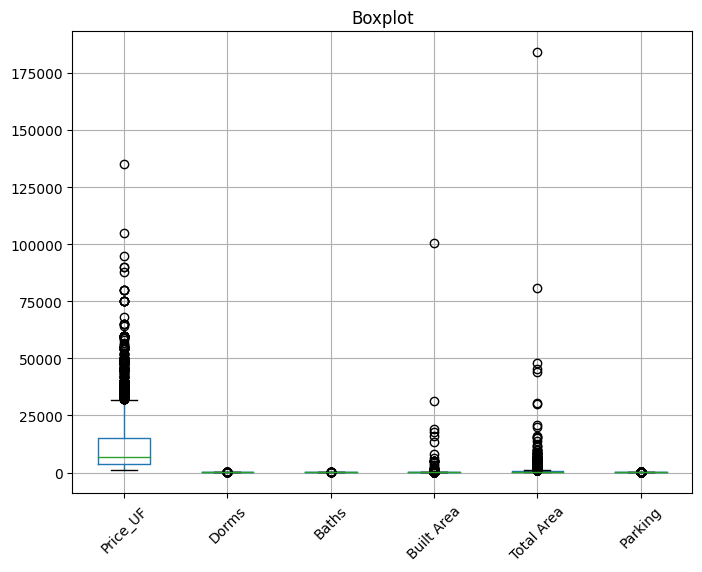

In [18]:
# Análisis de Outliers
df_casas.boxplot(figsize=(8, 6))
plt.title('Boxplot')
plt.xticks(rotation=45)
plt.show()

In [19]:
#Se eliminan NaNs y Outliers
df_casas.dropna(how='any',inplace=True)
df_casas=df_casas[(df_casas['Total Area']<250000) & (df_casas['Built Area']<300000)]

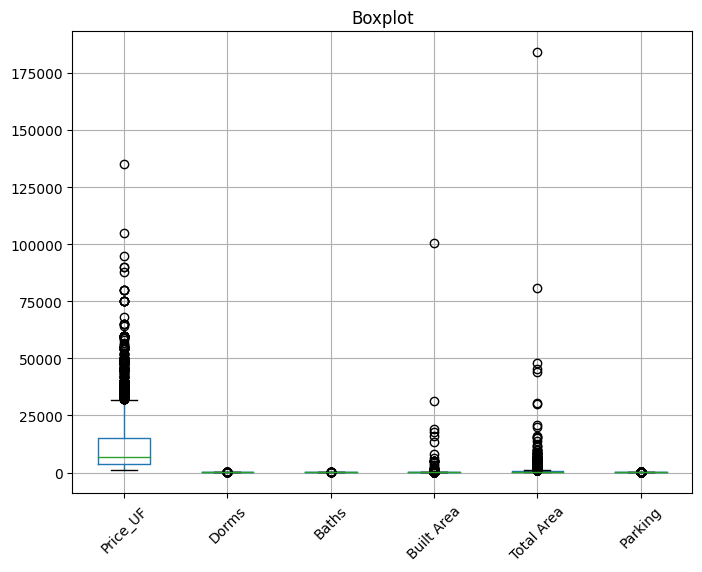

In [20]:
df_casas.boxplot(figsize=(8, 6))
plt.title('Boxplot')
plt.xticks(rotation=45)
plt.show()

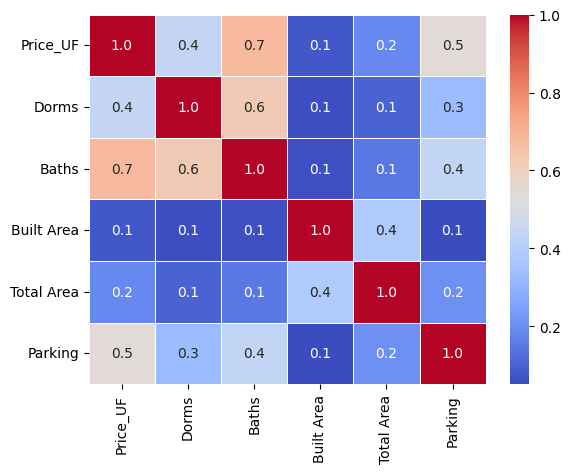

In [21]:
sns.heatmap(df_casas.corr(),annot=True,fmt=".1f",cmap='coolwarm',linewidths=0.5)
plt.show()

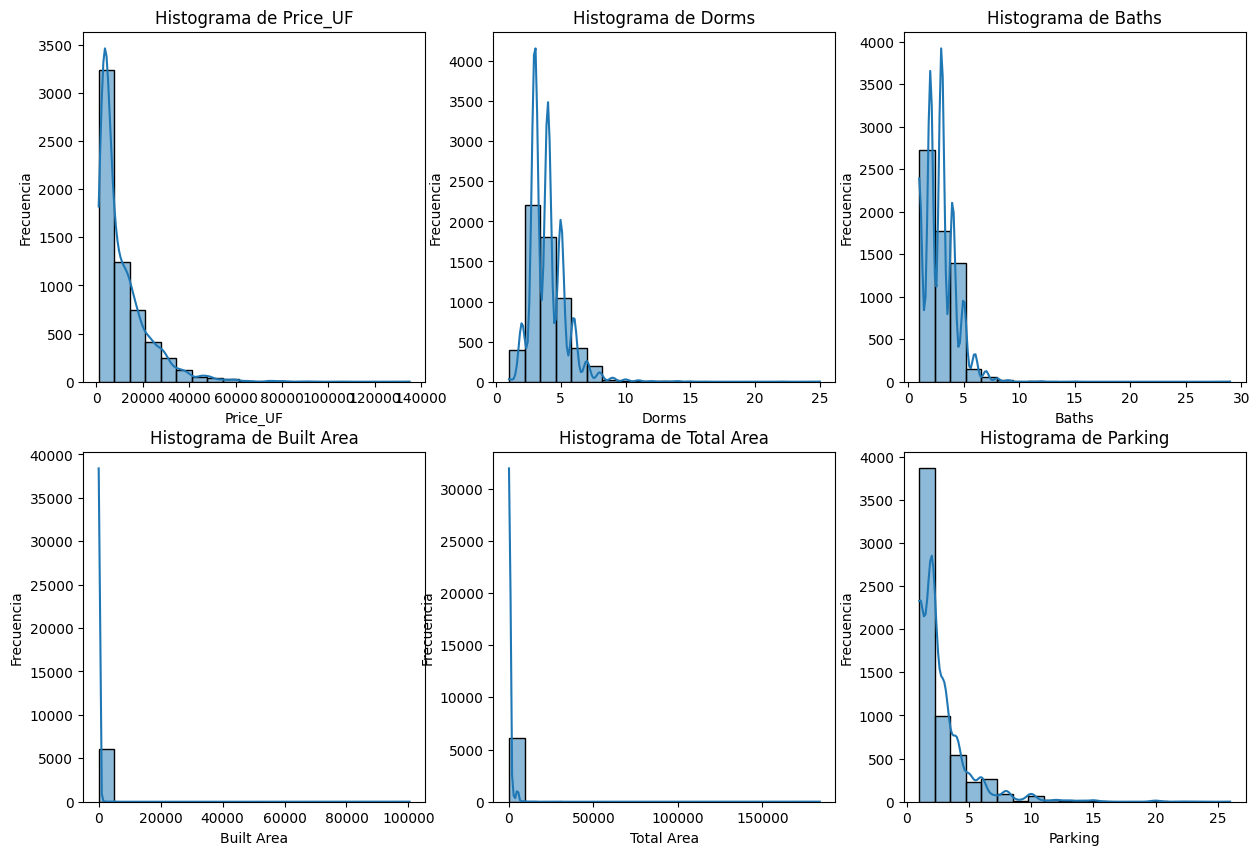

In [25]:
ncols=3
nrows=2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

axes = axes.flatten()  

for i, column in enumerate(df_casas.columns):
    sns.histplot(df_casas[column], ax=axes[i], kde=True,bins=20,palette='tab10')
    axes[i].set_title(f'Histograma de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frecuencia')


### Aplicación de Modelos de Regresión

In [247]:
y=df_casas['Price_UF']
X=df_casas
del X['Price_UF'], X['Comuna']

In [248]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [272]:
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
                            }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.1, 0.5, 0.9],
            'fit_intercept': [True, False]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion': ['mse', 'friedman_mse', 'mae'],
            'splitter': ['best', 'random']
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'criterion': ['squared_error', 'absolute_error','friedman_mse']
        }
    },

    'KNeighborsRegressor':{
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors':[3,5,6,10],
            'weights':['uniform','distance'],
            'metric':['cosine','euclidean','manhattan']
        }

    },
    'GradientBoostingRegressor':{
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'criterion': ['squared_error', 'friedman_mse']
        }

    },
    'XGBoostRegressor':{
        'model': xgb.XGBRegressor(objective='reg:squarederror'),
        'params': {'n_estimators': [100, 300, 500],
                   'learning_rate': [0.01, 0.1, 0.2],
                   'max_depth': [3, 5, 7],
                   'subsample': [0.7, 0.8, 0.9],
                   'colsample_bytree': [0.7, 0.8, 1.0],
                   'min_child_weight': [1, 3, 5],
                   'reg_alpha': [0, 0.1, 0.5],
                   'reg_lambda': [0.1, 0.5, 1.0]
        }
    }
    
}

    


In [273]:
X_train_sc=sc.fit_transform(X_train)
X_test_sc=sc.transform(X_test)

In [274]:
results=[]
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'}

for model_name, model in models.items():

  grid = GridSearchCV(model['model'], model['params'], cv=5, scoring=scoring,n_jobs=-1,refit='R2')
  grid.fit(X_train_sc, y_train)

  results.append({
      'Modelo': model_name,
      'Best_Estimator': grid.best_estimator_,
      'Best_Params': grid.best_params_,
      'Best_R2_Score': grid.best_score_,
      'Best_MAE': -grid.cv_results_['mean_test_MAE'][grid.best_index_],  
      'Best_MSE': -grid.cv_results_['mean_test_MSE'][grid.best_index_] })

results_df=pd.DataFrame(results)


,Modelo,Best_Estimator,Best_Params,Best_R2_Score,Best_MAE,Best_MSE
0,LinearRegression,LinearRegression(),{'fit_intercept': True},0.497455,4852.336364,5.902031e+07
1,ElasticNet,"ElasticNet(alpha=1, l1_ratio=0.9)","{'alpha': 1, 'fit_intercept': True, 'l1_ratio'...",0.506360,4828.736908,5.808183e+07
2,Ridge,Ridge(alpha=10),"{'alpha': 10, 'fit_intercept': True}",0.497966,4850.527016,5.896471e+07
3,Lasso,Lasso(alpha=10),"{'alpha': 10, 'fit_intercept': True}",0.499507,4850.767381,5.879314e+07
4,DecisionTree,DecisionTreeRegressor(criterion='friedman_mse'),"{'criterion': 'friedman_mse', 'splitter': 'best'}",0.576192,3950.164893,5.007359e+07
5,RandomForest,(DecisionTreeRegressor(criterion='absolute_err...,"{'criterion': 'absolute_error', 'n_estimators'...",0.765148,3028.442840,2.766856e+07
6,KNeighborsRegressor,"KNeighborsRegressor(metric='manhattan', n_neig...","{'metric': 'manhattan', 'n_neighbors': 10, 'we...",0.688597,3363.442964,3.673712e+07
7,GradientBoostingRegressor,([DecisionTreeRegressor(criterion='friedman_ms...,"{'criterion': 'friedman_mse', 'n_estimators': ...",0.774605,2979.170357,2.658703e+07
8,XGBoostRegressor,"XGBRegressor(base_score=None, booster=None, ca...","{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.773993,2957.183653,2.664465e+07


### Clusterización de Variables usando K-Means

In [334]:
df_X_escalado=pd.DataFrame(sc.fit_transform(X),columns=X.columns)
#df_X_escalado

In [281]:
from sklearn.cluster import KMeans

inertia=[]
for i in range(1,16):
    kmeans = KMeans(n_clusters=i).fit(df_X_escalado)
    inertia.append(kmeans.inertia_)

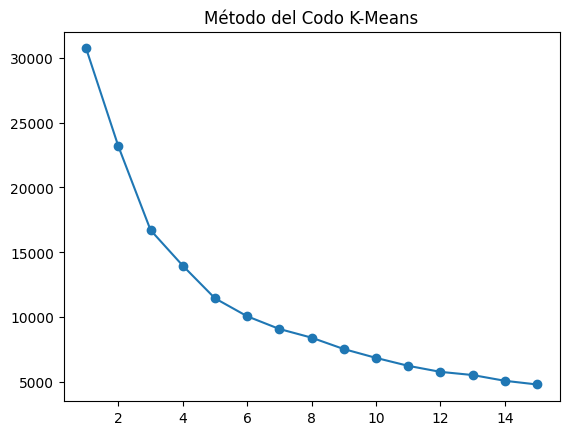

In [282]:
plt.plot(range(1,16),inertia,marker='o')
plt.title('Método del Codo K-Means')
plt.show()

In [283]:
kmeans = KMeans(n_clusters=5).fit(df_X_escalado)

In [293]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

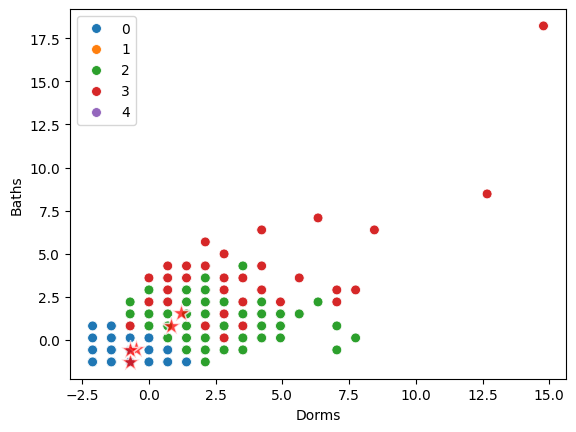

In [333]:
sns.scatterplot(x=df_X_escalado.iloc[:,0],y=df_X_escalado.iloc[:,1] ,hue=labels, s=50,palette='tab10')
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='red', s=200, alpha=0.75, marker='*')
plt.show()